In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core import display as ICD
import seaborn as sns
import glob
import scipy
import os
pd.set_option('display.max_columns', 100)
from helpers import *

In [80]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
DATA_FOLDER = './'

In [4]:
os.listdir(DATA_FOLDER)

['py_scripts',
 'neural_network.ipynb',
 'regression_mat_year.csv',
 'loss_log',
 '__pycache__',
 'ridge_regression.ipynb',
 '.ipynb_checkpoints',
 'feature_selection_rf.ipynb',
 'helpers.py',
 'feature_selection_stepwise.ipynb']

### Regression matrix manipulation

Importing regression matrix

In [5]:
tot_df=pd.read_csv(DATA_FOLDER+'regression_mat_year.csv',index_col=0)

Transform absolute value and direction in vector components

In [6]:
tot_df=vectorize_wind_speed(tot_df)

In [7]:
tot_df.shape

(535470, 23)

Shorten the matrix for developping purposes

In [8]:
tot_df_small=tot_df
tot_df_small.shape

(535470, 23)

### Splitting Data pandas

In [9]:
tot_df_small_tr, tot_df_small_te=split_data(tot_df_small,0.3)

In [10]:
tot_df_tr, tot_df_te=split_data(tot_df,0.3)

### Standardize the features pandas

In [11]:
# for trying small dataset and debugging purposes
X_small_tr_standard=(tot_df_small_tr.drop(columns=['u_x', 'u_y','u_z'])-tot_df_small_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/tot_df_small_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [12]:
X_tr_standard=(tot_df_tr.drop(columns=['u_x', 'u_y','u_z'])-tot_df_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/tot_df_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [13]:
y_tr_small=tot_df_small_tr[['u_x','u_y']]

In [14]:
y_tr=tot_df_tr[['u_x','u_y']]

In [15]:
# for trying small dataset and debugging purposes
X_small_te_standard=(tot_df_small_te.drop(columns=['u_x', 'u_y','u_z'])-tot_df_small_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/tot_df_small_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [16]:
X_te_standard=(tot_df_te.drop(columns=['u_x', 'u_y','u_z'])-tot_df_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/tot_df_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [63]:
X_te_standard.shape

(374829, 20)

In [17]:
y_te_small=tot_df_small_te[['u_x','u_y']]

In [18]:
y_te=tot_df_te[['u_x','u_y']]

# Stepwise feature selection for one year

A method to define the most important number of features is backward selection: in this case at the beginning all the features are considered to be important. From a physical point of view, however, it is clear that the free stream wind speed `u_top_x`, `u_top_y` and `h` are going to be important. As a consequence forward feature selection will be implemented. The null hypothesis is that the true regression matrix is only composed by the three columns chosen and at every step a column will be added if the improvement in the value of $R^2$ is more unlikly than the significant level chosen. Then Bidirectional elimination is also implemented: consequently a backward step will be implemented to check if the new column added has a strong covariance with one the previous added columns. In this way the order to addition of the columns won't matter.

In [102]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.005, 
                       threshold_out = 0.1, 
                       verbose=True):
    
    # the threshold in is specified at 0.01 confidence level for the output meaning that for each\
    # velocity component is going to be 0.005 using bonferroni method
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        
        # make a new series with a set of index being the columns you start with
        new_pval = pd.Series(index=excluded)
        
        for new_column in excluded:
            # make the model by adding a column. N.B the order to addition of columns doesn't matter since 
            # all parameters are added one by one and then the most unlikely is selected on the base that the
            # hypothesis of having the estimators being B=0
            
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            # the parameter used to calculate a two tail relative significance level can be obtained
            #based on the R square value of the regression and the 
            
            new_pval[new_column] = model.pvalues[new_column]
        
        # add the column which produced the most unluckily p value
        best_pval = new_pval.min()
        
        # here it starts the backward step. this is useful to contract the order of selection of the features
        # the order of selection matters so the features will only be kept if their removal is significant
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
                
        print ('eigenvalues are', np.linalg.eig(X[included].T@X[included])[0])
        
        print ('the condition number of the matrix is', np.sqrt(np.max(np.linalg.eig(X[included].T@X[included])[0])/np.min(np.linalg.eig(X[included].T@X[included])[0])))
        print ('the set of condition indices of the matrix are', np.sqrt(np.max(np.linalg.eig(X[included].T@X[included])[0])/np.linalg.eig(X[included].T@X[included])[0]))

        # plot the heatmap
        sns.heatmap(pd.DataFrame(X[included]).corr(), 
        xticklabels=pd.DataFrame(X[included]).corr().columns,
        yticklabels=pd.DataFrame(X[included]).corr().columns)
        
        plt.show()


        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        reg = LinearRegression().fit(X[included], y)
        print ('scikit mse', mean_squared_error(y,reg.predict(X[included])))
        print ('Sum of squared residuals', model.ssr)
        print ('mse', model.mse_total)
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
                reg = LinearRegression().fit(X[included], y)
                print ('scikit mse', mean_squared_error(y,reg.predict(X[included])))
                print ('Sum of squared residuals', model.ssr)
                print ('mse', model.mse_total)
        if not changed:
            break
    return included

Perform the stepwise feature selection for the x component of velocity of u

Add  Sky temperature [°C]           with p-value 0.0
eigenvalues are [160640.]
the condition number of the matrix is 1.0
the set of condition indices of the matrix are [1.]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


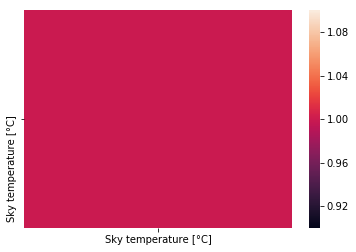

scikit mse 1.2082052189502241
Sum of squared residuals 194087.29457738283
mse 1.2261405086723822
Add  u_top_x                        with p-value 0.0
eigenvalues are [125789.51642708 195490.48357292]
the condition number of the matrix is 1.2466386480183387
the set of condition indices of the matrix are [1.24663865 1.        ]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


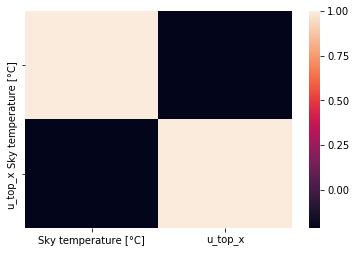

scikit mse 0.8806250074910389
Sum of squared residuals 141464.48182836795
mse 1.2261405086723822


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Radiometer Ground temperature [°C] with p-value 0.0
eigenvalues are [290432.54813075  49276.4755162  142210.97635305]
the condition number of the matrix is 2.427743633131316
the set of condition indices of the matrix are [1.         2.42774363 1.42907849]


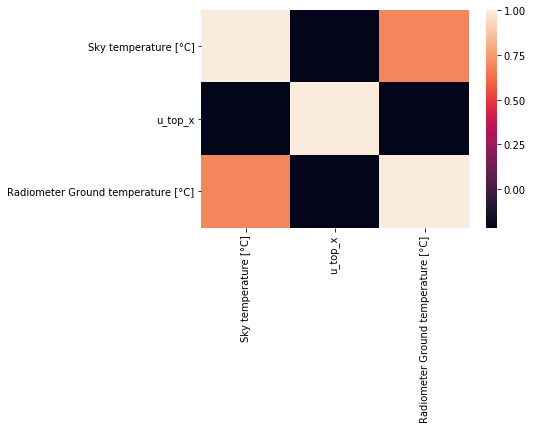

scikit mse 0.8722476362038666
Sum of squared residuals 140118.73252742534
mse 1.2261405086723822
Add  u_top_y                        with p-value 0.0
eigenvalues are [291260.94042726  43746.53523212 127513.2963749  180039.22796572]
the condition number of the matrix is 2.5802945948101184
the set of condition indices of the matrix are [1.         2.58029459 1.51134421 1.27191343]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


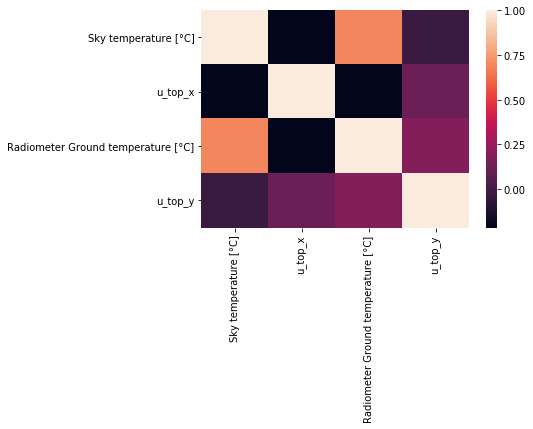

scikit mse 0.8356615541283215
Sum of squared residuals 134241.50771672768
mse 1.2261405086723822


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp                     with p-value 0.0
eigenvalues are [429725.61155651   9915.75126042  48726.04282923 133048.33568554
 181784.25866829]
the condition number of the matrix is 6.583135697394324
the set of condition indices of the matrix are [1.         6.5831357  2.96971688 1.79717718 1.53750835]


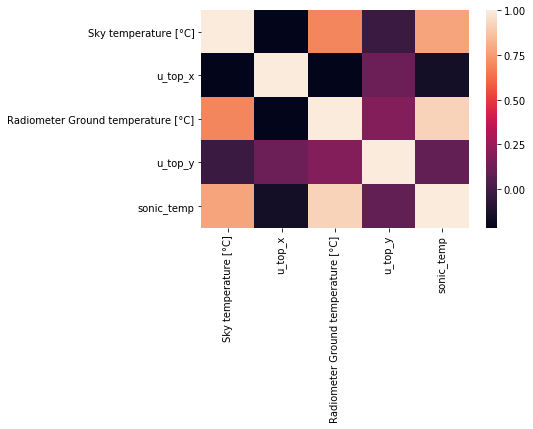

scikit mse 0.8212220804246785
Sum of squared residuals 131921.9362215008
mse 1.2261405086723822


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  u_top_z                        with p-value 4.84343e-92
eigenvalues are [429763.44210229   9674.13198025  48599.52262657 198232.9095565
 132997.9273332  144572.06640119]
the condition number of the matrix is 6.66513162942878
the set of condition indices of the matrix are [1.         6.66513163 2.97371082 1.47240355 1.79759685 1.72414005]


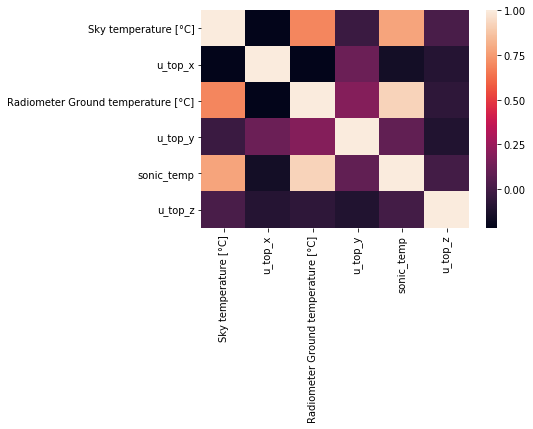

scikit mse 0.819108079433007
Sum of squared residuals 131582.3409881977
mse 1.2261405086723822


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  West temperature [°C]          with p-value 3.32267e-88
eigenvalues are [578632.05939014 198858.45054323 133384.06382213 144737.82353202
  53216.01339808   9752.17492398   5899.41439041]
the condition number of the matrix is 9.903684451483121
the set of condition indices of the matrix are [1.         1.70580436 2.08280818 1.99944852 3.29746411 7.7028334
 9.90368445]


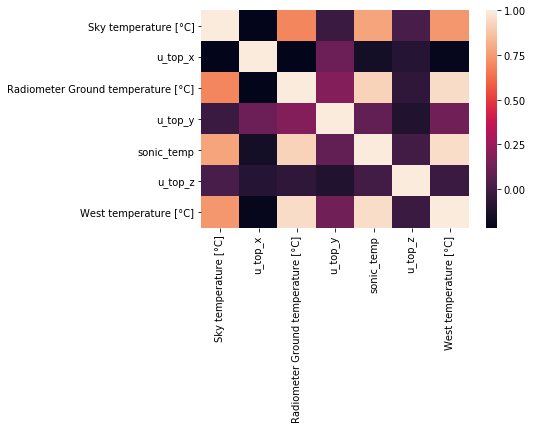

scikit mse 0.8170891486820804
Sum of squared residuals 131258.01793343812
mse 1.2261405086723822


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  South temperature [°C]         with p-value 9.26343e-40
eigenvalues are [734569.42486311 199132.80661853 144831.077109   134097.23937009
  54652.43339405  10030.60597205   1536.95473259   6269.45794057]
the condition number of the matrix is 21.861798422032813
the set of condition indices of the matrix are [ 1.          1.92063579  2.25208897  2.34048847  3.66616217  8.55761686
 21.86179842 10.82434005]


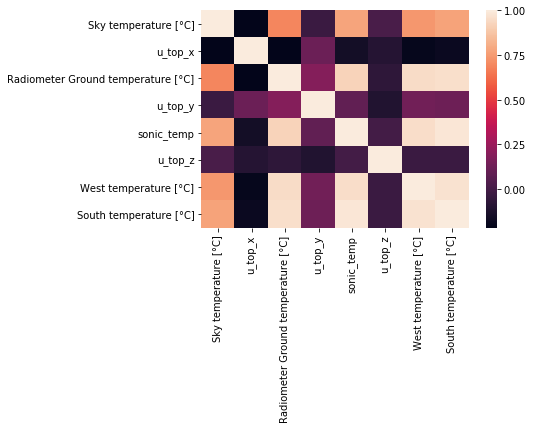

scikit mse 0.8162038663818901
Sum of squared residuals 131115.8052994532
mse 1.2261405086723822


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  h                              with p-value 1.26616e-40
eigenvalues are [734577.62310213 199133.05734649 160736.76334265 144828.99508799
 134094.92742878  54646.44267538   1506.44446809   9980.10499163
   6255.64155719]
the condition number of the matrix is 22.082197195159026
the set of condition indices of the matrix are [ 1.          1.92064529  2.13777128  2.25211773  2.3405217   3.66638358
 22.0821972   8.57928889 10.83634739]


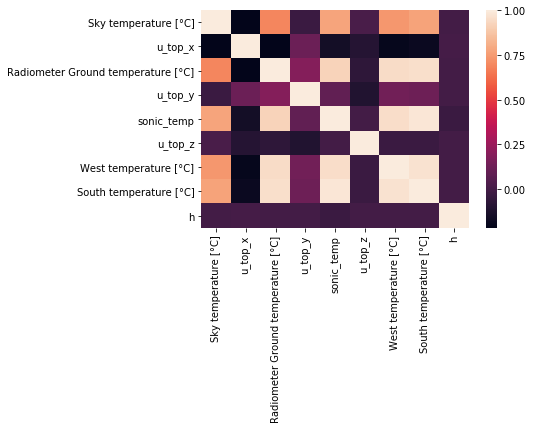

scikit mse 0.8152994485047677
Sum of squared residuals 130970.5187072544
mse 1.2261405086723822


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  North temperature [°C]         with p-value 2.42082e-21
eigenvalues are [882374.14684449 200037.05331959 160741.55252358 144857.0546335
 134095.10497134  58955.80254651  13696.10233826   6675.17203759
   1309.49918336   3658.5116021 ]
the condition number of the matrix is 25.958152022969305
the set of condition indices of the matrix are [ 1.          2.10025082  2.34294616  2.46806482  2.56519229  3.86868268
  8.02653107 11.49728127 25.95815202 15.53009703]


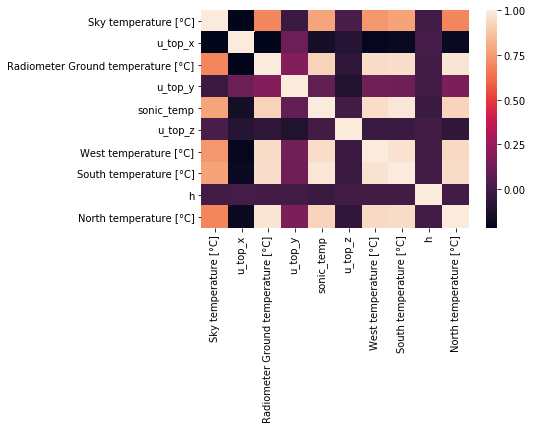

scikit mse 0.8148429316872475
Sum of squared residuals 130897.18338917114
mse 1.2261405086723822


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp_top                 with p-value 1.48312e-11
eigenvalues are [1.03396247e+06 2.00049520e+05 1.60743374e+05 1.45205101e+05
 1.35935972e+05 5.90529963e+04 1.89171871e+04 7.65658983e+03
 3.76582477e+03 3.50932102e+02 1.40003484e+03]
the condition number of the matrix is 54.28012490209375
the set of condition indices of the matrix are [ 1.          2.2734407   2.53621371  2.66846463  2.75794238  4.1843829
  7.39305791 11.62076439 16.56999333 54.2801249  27.17583932]


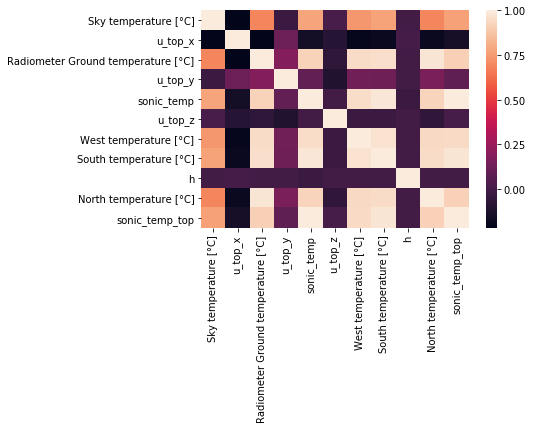

scikit mse 0.8146118644475907
Sum of squared residuals 130860.0645167254
mse 1.2261405086723822


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sensor Ground temperature [°C] with p-value 4.13623e-10
eigenvalues are [1.17448942e+06 2.00888567e+05 1.60746447e+05 1.45208085e+05
 1.36405977e+05 6.15901296e+04 2.37620891e+04 1.35005346e+04
 7.25491363e+03 2.18987680e+03 3.50930370e+02 1.29303274e+03]
the condition number of the matrix is 57.85142711384827
the set of condition indices of the matrix are [ 1.          2.41794793  2.70304866  2.84399713  2.93432257  4.36685725
  7.03043575  9.32715234 12.72355381 23.1587286  57.85142711 30.13837232]


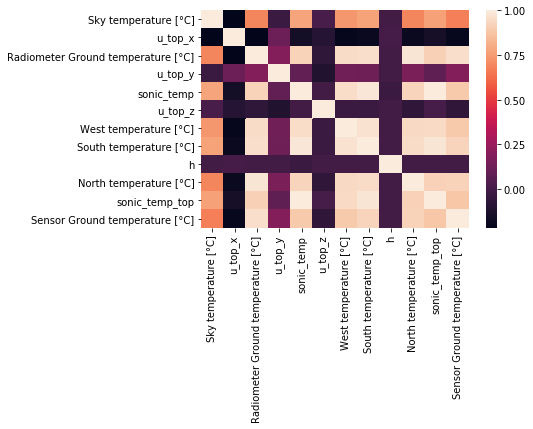

scikit mse 0.8144138617758685
Sum of squared residuals 130828.25716953733
mse 1.2261405086723822


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyrgeometer Lower Irradiance [W/m$^2$] with p-value 0.000642321
eigenvalues are [1.32513879e+06 2.01684859e+05 1.60749083e+05 1.45219927e+05
 1.37124077e+05 6.52761035e+04 2.71011364e+04 1.40506256e+04
 7.25861162e+03 2.58721432e+03 1.62959536e+03 1.49011190e+02
 3.50960613e+02]
the condition number of the matrix is 94.30207371669492
the set of condition indices of the matrix are [ 1.          2.56326812  2.87115364  3.02076943  3.1086643   4.50560975
  6.99257178  9.71142259 13.51151054 22.63155948 28.51614372 94.30207372
 61.44711464]


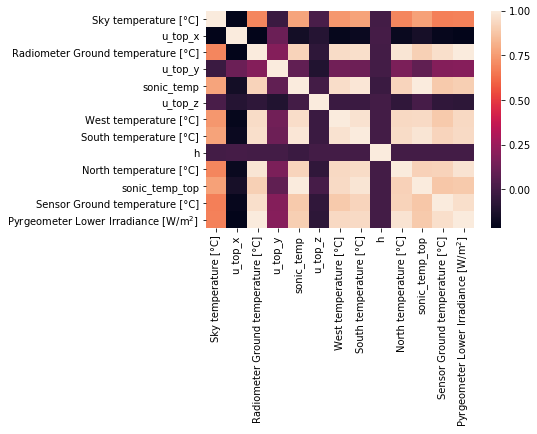

scikit mse 0.8143548000436989
Sum of squared residuals 130818.76943381983
mse 1.2261405086723822
Drop Radiometer Ground temperature [°C] with p-value 0.69326


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:79: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


scikit mse 0.8143555888080805


ValueError: x and y must have same first dimension, but have shapes (2000,) and (160641,)

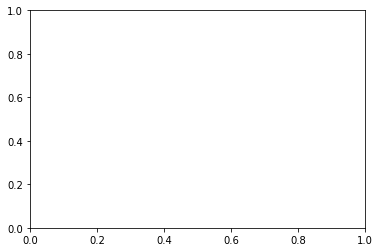

In [100]:
result = stepwise_selection(X_small_tr_standard, y_tr_small.iloc[:,0], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

Perform the stepwise feature selection for the y component of the velocity of u

In [26]:
result = stepwise_selection(X_small_tr_standard, y_tr_small.iloc[:,1], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  u_top_z                        with p-value 2.15848e-33
Add  Net Far Infrared radiation [W/m$^2$] with p-value 2.63548e-33
Add  Net (total) radiation [W/m$^2$] with p-value 3.71178e-59
Add  Sensor Ground temperature [°C] with p-value 1.22336e-28
Add  North temperature [°C]         with p-value 1.7022e-23
Add  Sky temperature [°C]           with p-value 3.39554e-44
Drop Sensor Ground temperature [°C] with p-value 0.210017


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:62: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  Pyranometer Lower Irradiance [W/m$^2$] with p-value 2.96997e-30
Add  East temperature [°C]          with p-value 2.04665e-06
Add  sonic_temp                     with p-value 4.59873e-06
Add  sonic_temp_top                 with p-value 3.13838e-77
Drop h                              with p-value 0.245042
Add  West temperature [°C]          with p-value 1.29486e-06
Add  Radiometer Ground temperature [°C] with p-value 0.000103304
Drop Net Far Infrared radiation [W/m$^2$] with p-value 0.292728
Add  South temperature [°C]         with p-value 0.000134724
resulting features:
['u_top_y', 'u_top_x', 'u_top_z', 'Net (total) radiation [W/m$^2$]', 'North temperature [°C]', 'Sky temperature [°C]', 'Pyranometer Lower Irradiance [W/m$^2$]', 'East temperature [°C]', 'sonic_temp', 'sonic_temp_top', 'West temperature [°C]', 'Radiometer Ground temperature [°C]', 'South temperature [°C]']


In [ ]:
tot_df_small_standard.columns.values

# Stepwise feature selection for each season

In [39]:
df_spring, df_summer, df_autumn, df_winter=season_splitter(tot_df)

In [40]:
df_spring_tr, df_spring_te=split_data(df_spring,0.3)
df_summer_tr, df_summer_te=split_data(df_summer,0.3)
df_autumn_tr, df_autumn_te=split_data(df_autumn,0.3)
df_winter_tr, df_winter_te=split_data(df_winter,0.3)

In [41]:
X_spring_tr_standard=(df_spring_tr.drop(columns=['u_x', 'u_y','u_z'])-df_spring_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_spring_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_autumn_tr_standard=(df_autumn_tr.drop(columns=['u_x', 'u_y','u_z'])-df_autumn_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_autumn_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_summer_tr_standard=(df_summer_tr.drop(columns=['u_x', 'u_y','u_z'])-df_summer_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_summer_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_winter_tr_standard=(df_winter_tr.drop(columns=['u_x', 'u_y','u_z'])-df_winter_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_winter_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [42]:
y_spring_tr=df_spring_tr[['u_x','u_y']]
y_summer_tr=df_summer_tr[['u_x','u_y']]
y_autumn_tr=df_autumn_tr[['u_x','u_y']]
y_winter_tr=df_winter_tr[['u_x','u_y']]

In [43]:
X_spring_te_standard=(df_spring_te.drop(columns=['u_x', 'u_y','u_z'])-df_spring_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_spring_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_autumn_te_standard=(df_autumn_te.drop(columns=['u_x', 'u_y','u_z'])-df_autumn_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_autumn_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_summer_te_standard=(df_summer_te.drop(columns=['u_x', 'u_y','u_z'])-df_summer_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_summer_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_winter_te_standard=(df_winter_te.drop(columns=['u_x', 'u_y','u_z'])-df_winter_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_winter_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [44]:
y_spring_te=df_spring_te[['u_x','u_y']]
y_summer_te=df_summer_te[['u_x','u_y']]
y_autumn_te=df_autumn_te[['u_x','u_y']]
y_winter_te=df_winter_te[['u_x','u_y']]

### Spring

Perform the stepwise feature selection for the x component of velocity of u

In [34]:
result = stepwise_selection(X_spring_tr_standard, y_spring_tr.iloc[:,0], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Net Solar radiation [W/m$^2$]  with p-value 0.0
Add  u_top_z                        with p-value 2.36356e-46
Add  Net Far Infrared radiation [W/m$^2$] with p-value 6.03955e-16
Add  sonic_temp                     with p-value 2.5763e-09
Add  Radiometer Ground temperature [°C] with p-value 1.45747e-69
Drop Net Far Infrared radiation [W/m$^2$] with p-value 0.539045


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:62: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  West temperature [°C]          with p-value 5.82356e-44
Add  East temperature [°C]          with p-value 6.20289e-10
Add  South temperature [°C]         with p-value 2.23759e-16
Drop Net Solar radiation [W/m$^2$]  with p-value 0.460525
Add  sonic_temp_top                 with p-value 0.000147081
Add  Sensor Ground temperature [°C] with p-value 8.48581e-05
Add  North temperature [°C]         with p-value 1.92986e-07
resulting features:
['u_top_y', 'u_top_x', 'h', 'u_top_z', 'sonic_temp', 'Radiometer Ground temperature [°C]', 'West temperature [°C]', 'East temperature [°C]', 'South temperature [°C]', 'sonic_temp_top', 'Sensor Ground temperature [°C]', 'North temperature [°C]']


Perform the stepwise feature selection for the y component of velocity of u

In [35]:
result = stepwise_selection(X_spring_tr_standard, y_spring_tr.iloc[:,1], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sky temperature [°C]           with p-value 1.64183e-08
Add  sonic_temp_top                 with p-value 4.11106e-14
Add  Net Far Infrared radiation [W/m$^2$] with p-value 8.65484e-11
Add  North temperature [°C]         with p-value 4.63508e-06
Add  Pyranometer Lower Irradiance [W/m$^2$] with p-value 3.00878e-05
Add  Net (total) radiation [W/m$^2$] with p-value 2.86421e-06
Add  East temperature [°C]          with p-value 0.000845914
Drop sonic_temp_top                 with p-value 0.296544


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:62: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  Pyrgeometer Lower Irradiance [W/m$^2$] with p-value 0.00116689
Add  Radiometer Ground temperature [°C] with p-value 0.00259041
resulting features:
['u_top_y', 'u_top_x', 'h', 'Sky temperature [°C]', 'Net Far Infrared radiation [W/m$^2$]', 'North temperature [°C]', 'Pyranometer Lower Irradiance [W/m$^2$]', 'Net (total) radiation [W/m$^2$]', 'East temperature [°C]', 'Pyrgeometer Lower Irradiance [W/m$^2$]', 'Radiometer Ground temperature [°C]']


### Summer

Perform the stepwise feature selection for x component of velocity u

Add  Radiometer Ground temperature [°C] with p-value 0.0
eigenvalues are [75185.2043072  24960.00195018 44252.79718648 48153.99655614]
the condition number of the matrix is 1.7355769937730667
the set of condition indices of the matrix are [1.         1.73557699 1.30345436 1.2495396 ]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


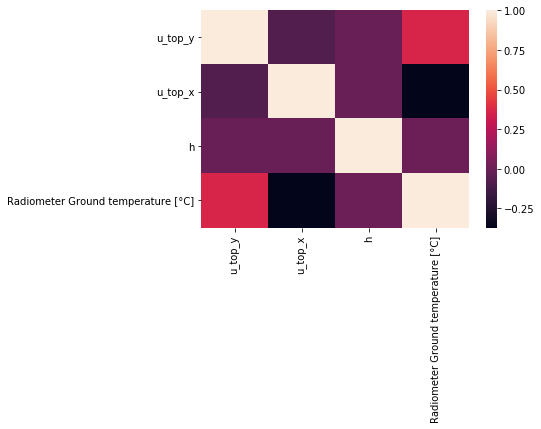

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:79: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


scikit mse 0.791577369233605
Sum of squared residuals 38105.7429775365
mse 1.1458334694892516
Drop h                              with p-value 0.565724
scikit mse 0.7915827944384278
Sum of squared residuals 38106.00414147148
mse 1.1458334694892516
Add  sonic_temp                     with p-value 1.24993e-209
eigenvalues are [104487.02229949   7319.73219171  36465.82514963  44279.42035918]
the condition number of the matrix is 3.778188140661675
the set of condition indices of the matrix are [1.         3.77818814 1.6927318  1.53613793]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


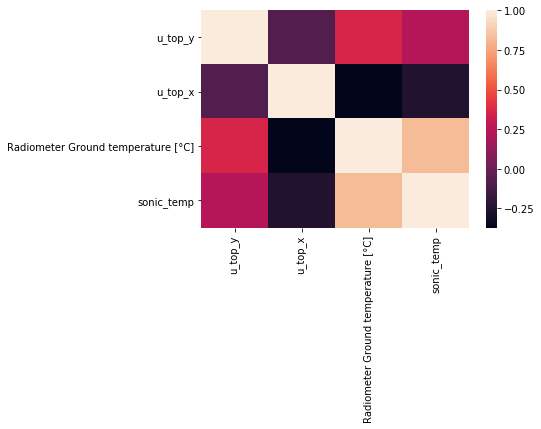

scikit mse 0.7760365804384964
Sum of squared residuals 37357.62494572878
mse 1.1458334694892516
Add  South temperature [°C]         with p-value 2.65823e-67
eigenvalues are [147177.30730136  44285.09780793  39816.94505355   7561.99175617
   1848.658081  ]
the condition number of the matrix is 8.92261449883185
the set of condition indices of the matrix are [1.         1.82302079 1.92258902 4.41166297 8.9226145 ]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


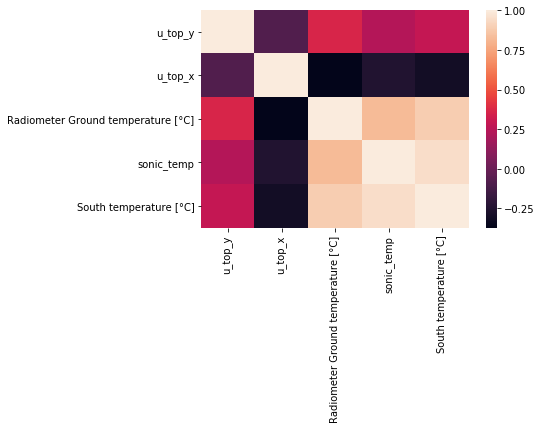

scikit mse 0.7712078932967414
Sum of squared residuals 37125.176775411834
mse 1.1458334694892516
Add  u_top_z                        with p-value 1.65927e-28
eigenvalues are [148650.35264672  57490.12071773  40071.74508244  33542.6709627
   7254.110533     1819.00005741]
the condition number of the matrix is 9.039962221316433
the set of condition indices of the matrix are [1.         1.60800117 1.92603353 2.10515535 4.52679563 9.03996222]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


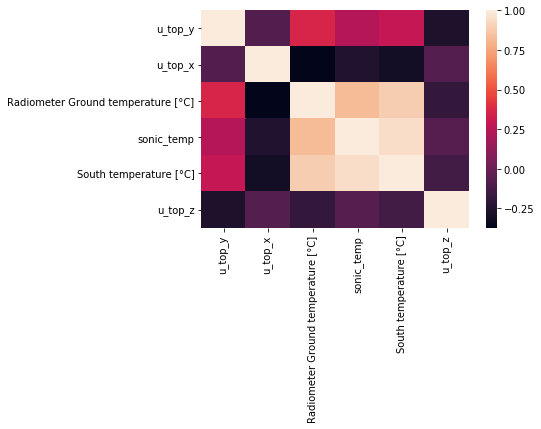

scikit mse 0.7692451011859796
Sum of squared residuals 37030.68992599186
mse 1.1458334694892516


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  West temperature [°C]          with p-value 4.66029e-16
eigenvalues are [188441.0235059   57939.48960314  40215.64244014  33595.53507356
   8415.02085744   6649.25680561   1710.03171421]
the condition number of the matrix is 10.497494234080557
the set of condition indices of the matrix are [ 1.          1.80343459  2.16466264  2.36835579  4.73216772  5.323548
 10.49749423]


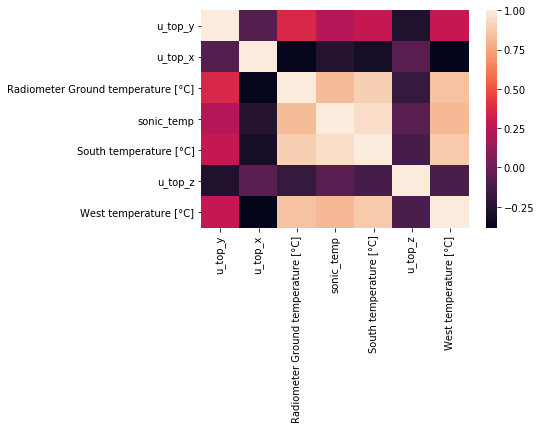

scikit mse 0.7681920165084548
Sum of squared residuals 36979.99548270051
mse 1.1458334694892516


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sky temperature [°C]           with p-value 1.37766e-10
eigenvalues are [213794.76476486  60371.19626542  41960.11368084  33742.22101399
  20040.57834902   1706.69732275   5813.09594974   7675.3326534 ]
the condition number of the matrix is 11.19232414848581
the set of condition indices of the matrix are [ 1.          1.8818441   2.25725282  2.51716509  3.26620476 11.19232415
  6.06449703  5.27776355]


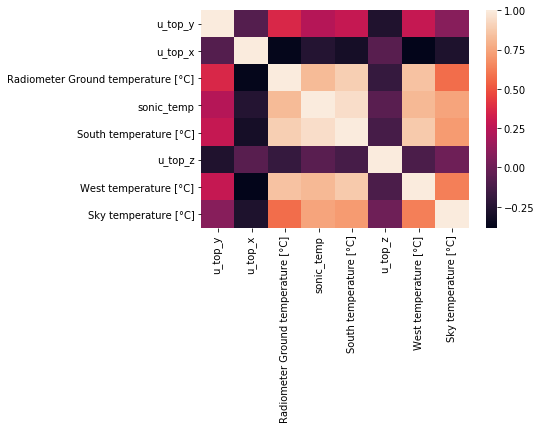

scikit mse 0.7675347850058098
Sum of squared residuals 36948.35701539467
mse 1.1458334694892516


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyrgeometer Upper Irradiance [W/m$^2$] with p-value 1.23697e-06
eigenvalues are [2.44958352e+05 6.46598474e+04 4.49237170e+04 3.41049958e+04
 2.91147963e+04 5.97972613e+03 7.76203024e+03 1.70694919e+03
 3.15861273e+01]
the condition number of the matrix is 88.06390409833962
the set of condition indices of the matrix are [ 1.          1.94638517  2.33511506  2.68001439  2.90060938  6.40037586
  5.61769893 11.97942102 88.0639041 ]


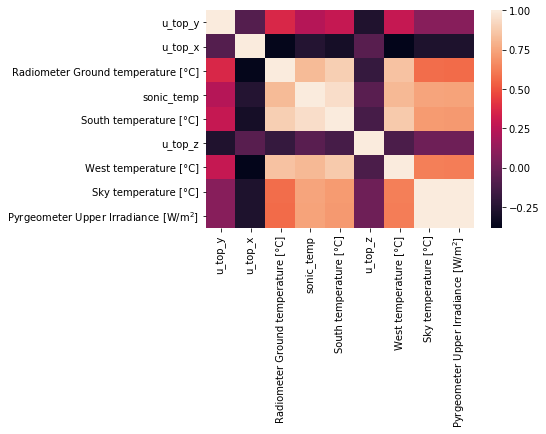

scikit mse 0.767159807410169
Sum of squared residuals 36930.30596891814
mse 1.1458334694892516


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  h                              with p-value 2.17161e-06
eigenvalues are [2.44961009e+05 6.46603542e+04 4.83860531e+04 4.48460138e+04
 3.40896008e+04 2.90984866e+04 3.15853938e+01 1.65247147e+03
 5.93922405e+03 7.71520125e+03]
the condition number of the matrix is 88.06540438617021
the set of condition indices of the matrix are [ 1.          1.9463881   2.25003038  2.33714985  2.68063401  2.90143791
 88.06540439 12.17535117  6.42219706  5.63475259]


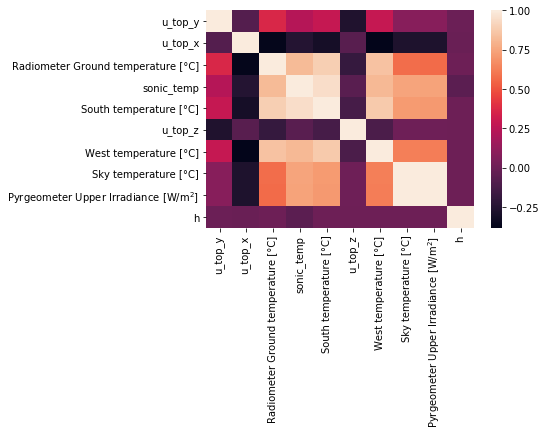

scikit mse 0.7668022430868032
Sum of squared residuals 36913.09317995562
mse 1.1458334694892516


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp_top                 with p-value 5.22427e-10
eigenvalues are [2.86630012e+05 6.48317617e+04 4.84176122e+04 4.56550837e+04
 3.47958558e+04 2.99977881e+04 1.03764329e+04 6.55468330e+03
 1.91120265e+03 3.13769494e+01 3.16190979e+02]
the condition number of the matrix is 95.57745716182295
the set of condition indices of the matrix are [ 1.          2.10264967  2.43309545  2.50562607  2.87010027  3.09112249
  5.25577529  6.6127937  12.2463724  95.57745716 30.10829016]


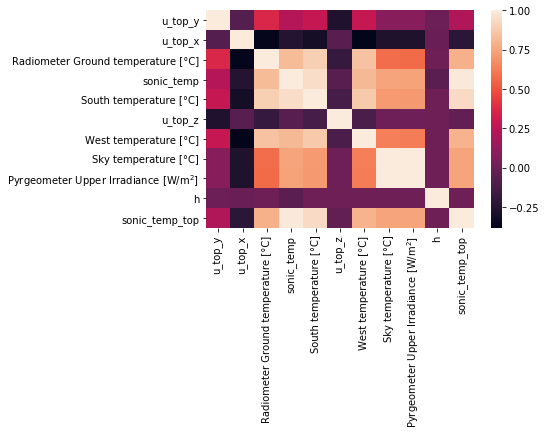

scikit mse 0.7661876070648079
Sum of squared residuals 36883.5052164928
mse 1.1458334694892516


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Net (total) radiation [W/m$^2$] with p-value 1.14372e-05
eigenvalues are [3.00739860e+05 7.47950688e+04 5.27413017e+04 4.81860352e+04
 3.48594202e+04 3.14550861e+04 2.36397088e+04 6.93950838e+03
 3.12513663e+01 3.06876660e+02 2.07170763e+03 1.89017540e+03]
the condition number of the matrix is 98.09818948341821
the set of condition indices of the matrix are [ 1.          2.00520608  2.38792166  2.49824427  2.93721283  3.09207527
  3.56676449  6.58311049 98.09818948 31.30498982 12.04845231 12.6137565 ]


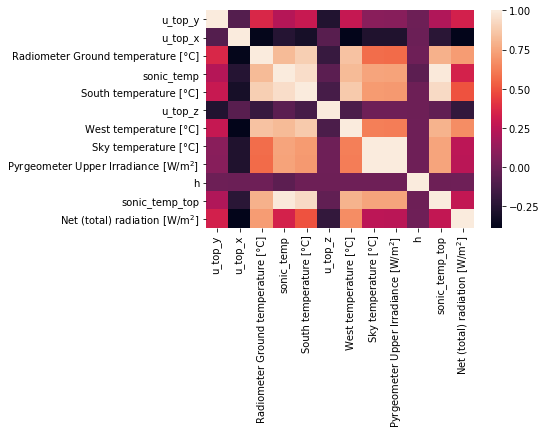

scikit mse 0.7658811171992298
Sum of squared residuals 36868.75110085372
mse 1.1458334694892516


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyranometer Upper Irradiance [W/m$^2$] with p-value 0.000229074
eigenvalues are [3.19844267e+05 9.59565686e+04 5.57354494e+04 4.82410743e+04
 3.48656439e+04 3.36865505e+04 2.59248239e+04 7.10014864e+03
 2.16955283e+03 1.91432107e+03 3.07538278e+02 1.67156969e+01
 3.13463071e+01]
the condition number of the matrix is 138.32702633549235
the set of condition indices of the matrix are [  1.           1.82571057   2.39554058   2.57490256   3.02879891
   3.08134988   3.51245992   6.71174681  12.14183063  12.92593286
  32.24925571 138.32702634 101.01272642]


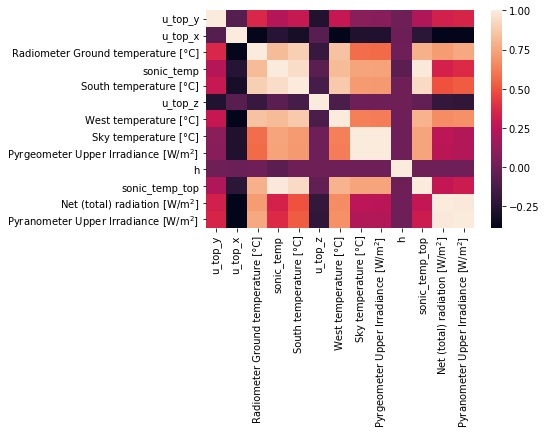

scikit mse 0.7656650884844214
Sum of squared residuals 36858.35169455155
mse 1.1458334694892516


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  East temperature [°C]          with p-value 0.00214229
eigenvalues are [3.62523002e+05 9.69586577e+04 5.57923297e+04 4.82415552e+04
 3.49529897e+04 3.41542080e+04 2.60645333e+04 7.47673883e+03
 3.95852401e+03 1.92521650e+03 1.52901214e+03 3.07506981e+02
 1.66839723e+01 3.10415392e+01]
the condition number of the matrix is 147.40698204628885
the set of condition indices of the matrix are [  1.           1.93363495   2.54906281   2.74130358   3.22051717
   3.25795945   3.72943299   6.96324505   9.56976212  13.72233432
  15.39792914  34.33525636 147.40698205 108.06776269]


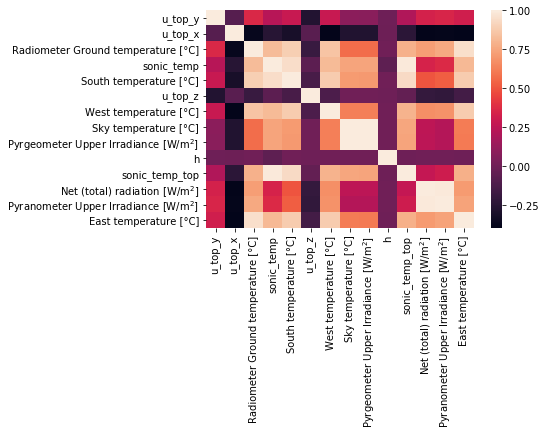

scikit mse 0.765515172278086
Sum of squared residuals 36851.13487829478
mse 1.1458334694892516


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  North temperature [°C]         with p-value 3.12359e-05
eigenvalues are [4.00790991e+05 9.92498075e+04 5.57930329e+04 4.82416688e+04
 3.45305483e+04 3.55665140e+04 2.63357532e+04 9.78278135e+03
 4.81918509e+03 3.80984667e+03 1.89266655e+03 9.15246035e+02
 3.01548294e+02 3.07723967e+01 9.63776673e+00]
the condition number of the matrix is 203.9251405399049
the set of condition indices of the matrix are [  1.           2.00952836   2.68021103   2.88235729   3.40688315
   3.35689939   3.9010912    6.40070486   9.11952403  10.2566427
  14.5519744   20.92618438  36.45696722 114.12434935 203.92514054]


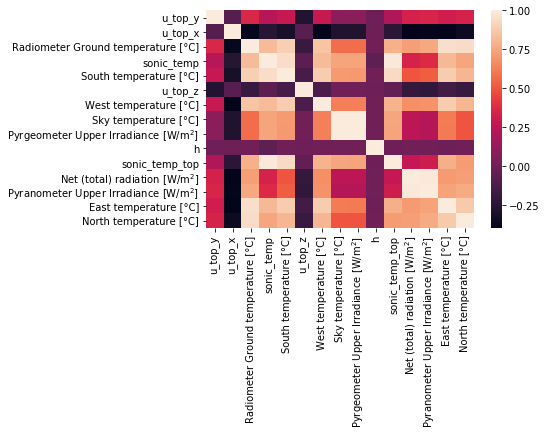

scikit mse 0.7652393662247787
Sum of squared residuals 36837.85785069462
mse 1.1458334694892516


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sensor Ground temperature [°C] with p-value 0.000820286
eigenvalues are [4.39464789e+05 9.93547391e+04 5.61221300e+04 4.82432409e+04
 3.45376822e+04 3.63016615e+04 2.74277196e+04 1.15912190e+04
 7.91707994e+03 3.81939910e+03 2.88020061e+03 1.74763473e+03
 4.58705726e+02 3.01404167e+02 3.07563517e+01 9.63770772e+00]
the condition number of the matrix is 213.53799792698635
the set of condition indices of the matrix are [  1.           2.10313789   2.79830449   3.01817074   3.56710134
   3.47935539   4.00283043   6.15740169   7.45039893  10.72666016
  12.35238084  15.85757263  30.95244505  38.18452705 119.53487531
 213.53799793]


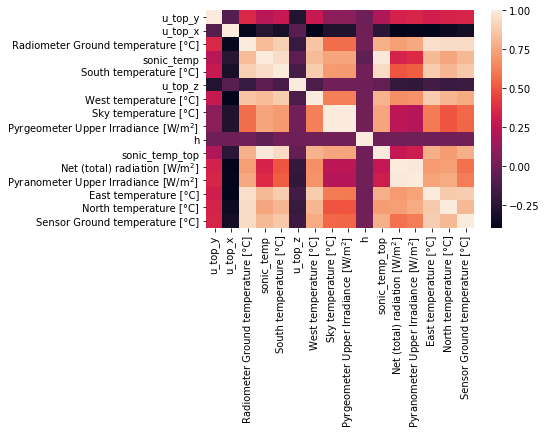

scikit mse 0.7650613652286603
Sum of squared residuals 36829.28906074248
mse 1.1458334694892516
eigenvalues are [4.39464789e+05 9.93547391e+04 5.61221300e+04 4.82432409e+04
 3.45376822e+04 3.63016615e+04 2.74277196e+04 1.15912190e+04
 7.91707994e+03 3.81939910e+03 2.88020061e+03 1.74763473e+03
 4.58705726e+02 3.01404167e+02 3.07563517e+01 9.63770772e+00]
the condition number of the matrix is 213.53799792698635
the set of condition indices of the matrix are [  1.           2.10313789   2.79830449   3.01817074   3.56710134
   3.47935539   4.00283043   6.15740169   7.45039893  10.72666016
  12.35238084  15.85757263  30.95244505  38.18452705 119.53487531
 213.53799793]


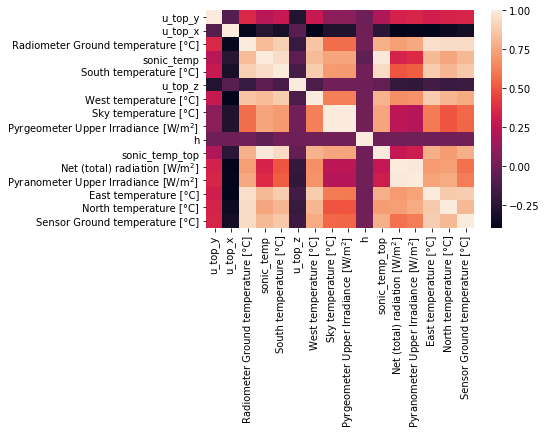

scikit mse 0.7650613652286603
Sum of squared residuals 36829.28906074248
mse 1.1458334694892516
resulting features:
['u_top_y', 'u_top_x', 'Radiometer Ground temperature [°C]', 'sonic_temp', 'South temperature [°C]', 'u_top_z', 'West temperature [°C]', 'Sky temperature [°C]', 'Pyrgeometer Upper Irradiance [W/m$^2$]', 'h', 'sonic_temp_top', 'Net (total) radiation [W/m$^2$]', 'Pyranometer Upper Irradiance [W/m$^2$]', 'East temperature [°C]', 'North temperature [°C]', 'Sensor Ground temperature [°C]']


In [103]:
result = stepwise_selection(X_summer_tr_standard, y_summer_tr.iloc[:,0], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

Perform the stepwise feature selection for the y component of velocity of u

In [37]:
result = stepwise_selection(X_summer_tr_standard, y_summer_tr.iloc[:,1], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyrgeometer Upper Irradiance [W/m$^2$] with p-value 3.00676e-63
Add  Pyranometer Upper Irradiance [W/m$^2$] with p-value 1.63034e-06
Add  sonic_temp                     with p-value 0.00388025
Add  sonic_temp_top                 with p-value 5.51518e-153
Add  u_top_z                        with p-value 7.03443e-08
resulting features:
['u_top_y', 'u_top_x', 'h', 'Pyrgeometer Upper Irradiance [W/m$^2$]', 'Pyranometer Upper Irradiance [W/m$^2$]', 'sonic_temp', 'sonic_temp_top', 'u_top_z']


### Winter

Perform the stepwise feature selection for the x component of velocity of u

In [42]:
result = stepwise_selection(X_winter_tr_standard, y_winter_tr.iloc[:,0], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Net Solar radiation [W/m$^2$]  with p-value 3.55438e-58
Add  sonic_temp                     with p-value 5.92245e-39
Add  Pyrgeometer Lower Irradiance [W/m$^2$] with p-value 1.5673e-45
Add  sonic_temp_top                 with p-value 7.31263e-06
Drop Net Solar radiation [W/m$^2$]  with p-value 0.208103


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:62: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  East temperature [°C]          with p-value 0.000269281
Add  North temperature [°C]         with p-value 0.00134734
Add  Sensor Ground temperature [°C] with p-value 0.00459355
resulting features:
['u_top_y', 'u_top_x', 'h', 'sonic_temp', 'Pyrgeometer Lower Irradiance [W/m$^2$]', 'sonic_temp_top', 'East temperature [°C]', 'North temperature [°C]', 'Sensor Ground temperature [°C]']


Perform the stepwise feature selection for the y component of velocity u

In [43]:
result = stepwise_selection(X_winter_tr_standard, y_winter_tr.iloc[:,1], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  u_top_z                        with p-value 6.73822e-26
Add  sonic_temp                     with p-value 1.22286e-26
Add  Pyrgeometer Upper Irradiance [W/m$^2$] with p-value 5.76596e-05
Add  Sky temperature [°C]           with p-value 6.27406e-19
resulting features:
['u_top_y', 'u_top_x', 'h', 'u_top_z', 'sonic_temp', 'Pyrgeometer Upper Irradiance [W/m$^2$]', 'Sky temperature [°C]']


### Autumn

Perform the stepwise feature selection for the x component of velocity of u

In [44]:
result = stepwise_selection(X_autumn_tr_standard, y_autumn_tr.iloc[:,0], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyranometer Lower Irradiance [W/m$^2$] with p-value 1.2576e-224
Add  u_top_z                        with p-value 7.10814e-78
Add  Pyrgeometer Upper Irradiance [W/m$^2$] with p-value 9.89929e-35
Add  Net Far Infrared radiation [W/m$^2$] with p-value 1.14009e-14
Add  sonic_temp_top                 with p-value 5.42044e-70
Add  South temperature [°C]         with p-value 5.42091e-62
Drop Pyranometer Lower Irradiance [W/m$^2$] with p-value 0.268612


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:62: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  North temperature [°C]         with p-value 4.51031e-20
Add  sonic_temp                     with p-value 4.52847e-12
Add  East temperature [°C]          with p-value 1.21693e-06
Add  Net (total) radiation [W/m$^2$] with p-value 3.19671e-11
Add  Sensor Ground temperature [°C] with p-value 2.09764e-11
Add  Radiometer Ground temperature [°C] with p-value 8.3854e-06
Add  West temperature [°C]          with p-value 0.000892906
resulting features:
['u_top_y', 'u_top_x', 'h', 'u_top_z', 'Pyrgeometer Upper Irradiance [W/m$^2$]', 'Net Far Infrared radiation [W/m$^2$]', 'sonic_temp_top', 'South temperature [°C]', 'North temperature [°C]', 'sonic_temp', 'East temperature [°C]', 'Net (total) radiation [W/m$^2$]', 'Sensor Ground temperature [°C]', 'Radiometer Ground temperature [°C]', 'West temperature [°C]']


Perform the stepwise feature selection for the y component of velocity u

In [45]:
result = stepwise_selection(X_autumn_tr_standard, y_autumn_tr.iloc[:,1], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyrgeometer Upper Irradiance [W/m$^2$] with p-value 3.82433e-36
Add  Net (total) radiation [W/m$^2$] with p-value 1.14854e-14
Add  North temperature [°C]         with p-value 5.55712e-14
Add  Pyranometer Upper Irradiance [W/m$^2$] with p-value 3.50709e-36
Add  East temperature [°C]          with p-value 1.73524e-11
Add  South temperature [°C]         with p-value 5.78652e-11
Add  Sky temperature [°C]           with p-value 6.12514e-07
Add  u_top_z                        with p-value 8.12656e-07
resulting features:
['u_top_y', 'u_top_x', 'h', 'Pyrgeometer Upper Irradiance [W/m$^2$]', 'Net (total) radiation [W/m$^2$]', 'North temperature [°C]', 'Pyranometer Upper Irradiance [W/m$^2$]', 'East temperature [°C]', 'South temperature [°C]', 'Sky temperature [°C]', 'u_top_z']


In [ ]:
def forward_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.005, 
                       threshold_out = 0.1, 
                       verbose=True):
    
    # the threshold in is specified at 0.01 confidence level for the output meaning that for each\
    # velocity component is going to be 0.005 using bonferroni method
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        
        # make a new series with a set of index being the columns you start with
        new_pval = pd.Series(index=excluded)
        
        for new_column in excluded:
            # make the model by adding a column. N.B the order to addition of columns doesn't matter since 
            # all parameters are added one by one and then the most unlikely is selected on the base that the
            # hypothesis of having the estimators being B=0
            
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            # the parameter used to calculate f distribution is the R square value of the regression and the 
            # relative significance level
            new_pval[new_column] = model.f_pvalue
        
        # add the column which produced the most unluckily p value
        best_pval = new_pval.min()
        
        # here it starts the backward step. this is useful to contract the order of selection of the features
        # the order of selection matters so the features will only be kept if their removal is significant
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

#         # backward step
#         model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
#         # use all coefs except intercept
#         pvalues = model.pvalues.iloc[1:]
#         worst_pval = pvalues.max() # null if pvalues is empty
#         if worst_pval > threshold_out:
#             changed=True
#             worst_feature = pvalues.argmax()
#             included.remove(worst_feature)
#             if verbose:
#                 print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
#         if not changed:
#             break
    return included

# Backward feature selection

In [ ]:
alphas=np.logspace(-1,10,100)

#leave one out cv method is used
estimator = RidgeCV(alphas, cv=None, store_cv_values=True)
selector=RFECV(estimator, min_features_to_select=3, step=1, verbose=False, cv=5)
selector = selector.fit(X_tr_scaled_small, y_tr_small[:,0].reshape(-1, 1))
selector.support_

In [ ]:
alphas=np.logspace(-1,10,100)

#leave one out cv method is used
estimator = RidgeCV(alphas, cv=None, store_cv_values=True)
selector=RFECV(estimator, min_features_to_select=3, step=1, verbose=False, cv=5)
selector = selector.fit(X_tr_scaled_small, y_tr_small[:,1].reshape(-1, 1))
selector.support_

In [ ]:
len(tot_df_small_standard.drop(columns=['u_x', 'u_y','u_z']).columns.values)
